In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

from sklearn import decomposition
from sklearn.linear_model import RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import random

%matplotlib inline

In [2]:
# Preparing MATLAB delta model outputs for classification

## Training data: one year of river bed elevations for each node, measured every ~ 0.4 hours 
## Training labels: will an avulsion occur within the next 23 days?


def detect_avulsions(bed_elevations, avulsion_period):
    # avulsion_period: Time period to predict if an avulsion will occur within

    average_elevation = (np.mean(bed_elevations[:, 1]) + np.mean(bed_elevations[:,2]))/2

    # Measures how much the two elevations change in the same direction
    measure_1 = np.abs(np.gradient(bed_elevations[:,2]) + np.gradient(bed_elevations[:,1])) / average_elevation

    # Measures how much the two elections change in opposing directions
    measure_2 = np.abs(np.gradient(bed_elevations[:,2]) - np.gradient(bed_elevations[:,1])) / average_elevation

    # Rewards moving in opposite directions, penalizes moving in the same direction
    measure_3 = measure_2 - measure_1
    
    # Peaks are at avulsion locations, with height and width parameters manually tuned
    measure_3_peaks = scipy.signal.find_peaks(measure_3, height = 0.25*np.ptp(measure_3), width = 40)[0]

    # Labels: Will an avulsion occur in the next 23 days?
    avulsion_coming = []
    for t in range(bed_elevations.shape[0]):
        avulsion_coming.append(any((measure_3_peaks - t < avulsion_period) & (measure_3_peaks - t > 0)))


    return avulsion_coming, measure_3_peaks



def prepare_data(file, avulsion_period, historical_period, training_dt):
    bed_elevations = scipy.io.loadmat(file)['eta_save'].T
    
    avulsion_coming, avulsion_locations = detect_avulsions(bed_elevations, avulsion_period)
    
    # Data: Elevation measurements of nodes over the preceding year
    X_train = []
    y_labels = []
    
    for t in np.arange(historical_period, bed_elevations.shape[0], training_dt):
        X_train.append(np.hstack([bed_elevations[t-historical_period:t, n] for n in range(7)]))
        y_labels.append(avulsion_coming[t])

    X_train = np.array(X_train)
    y_labels = np.array(y_labels)
    
    return X_train, y_labels, avulsion_locations

In [3]:
# Constructing training and testing datasets

def split_training_testing(avulsion_period, historical_period, training_dt):

    X = []
    y = []

    files = [f'data/{i}.mat' for i in range(0,28)]
    random.shuffle(files)

    training_files = files[:-9]
    testing_files = files[-8:]

    for file in training_files:
        X_train, y_labels, av_locs = prepare_data(file, avulsion_period, historical_period, training_dt)
        X.append(X_train)
        y.append(y_labels)

    X_train = np.vstack(X)
    y_train = np.hstack(y)


    X=[]
    y=[]
    avulsions = []
    for file in testing_files:
        X_test, y_test, av_locs = prepare_data(file, avulsion_period, historical_period, training_dt)
        X.append(X_test)
        y.append(y_test)
        avulsions.append(av_locs)

    X_test = np.vstack(X)
    y_test = np.hstack(y)

    avulsions_test = []
    for i in range(len(avulsions)):
        for j in range(len(avulsions[i])):
            avulsions_test.append(avulsions[i][j] + (20000-historical_period)*i)

    avulsions_test = np.array(avulsions_test)
    
    return X_train, y_train, X_test, y_test, avulsions_test

In [4]:
# Demonstrating 

avulsion_period_training = 1250
avulsion_period_testing = 2000

historical_period = 500
training_dt = 20
        
ea_validities = np.array([])
avulsions_preds = np.array([])

testing_accs = np.array([])
training_accs = np.array([])
        
for i in range(10):
    X_train, y_train, X_test, y_test, avulsions_test = split_training_testing(avulsion_period_training,
                                                                             historical_period,
                                                                             training_dt)

    pca = decomposition.PCA(n_components=200).fit(X_train)
    X_train_pc_space = pca.transform(X_train)
    X_test_pc_space = pca.transform(X_test)
        
    clf = RidgeClassifierCV().fit(X_train_pc_space, y_train)
#     print(f'Train data: {clf.score(X_train_pc_space, y_train)}')
#     print(f'Test data: {clf.score(X_test_pc_space, y_test)}')

    clf = LinearDiscriminantAnalysis().fit(X_train_pc_space, y_train)
#     print(f'Train data: {clf.score(X_train_pc_space, y_train)}')
#     print(f'Test data: {clf.score(X_test_pc_space, y_test)}')

    y_pred = clf.predict(X_test_pc_space)

    early_alerts = np.where((y_pred[:-1] == False) & (y_pred[1:] == True))

    early_alerts_validity = []
    for early_alert in early_alerts[0]:
        early_alerts_validity.append(any(np.isin(np.arange(early_alert*training_dt + historical_period, early_alert*training_dt + historical_period + avulsion_period_testing), avulsions_test)))

    avulsions_predicted = []
    for avulsion in avulsions_test:
        avulsions_predicted.append(np.any(np.array([(np.isin(np.arange(early_alert*training_dt + historical_period, early_alert*training_dt + historical_period + avulsion_period_testing), avulsion)) for early_alert in early_alerts[0]])))

    ea_validities = np.concatenate((ea_validities, np.float_(early_alerts_validity)))
    avulsions_preds = np.concatenate((avulsions_preds, np.float_(avulsions_predicted)))
    testing_accs = np.concatenate((testing_accs, [clf.score(X_test_pc_space, y_test)]))
    training_accs = np.concatenate((testing_accs, [clf.score(X_train_pc_space, y_train)]))
    
    print(f'Test {i+1}/10 Running Means:')
    print(f'Early alerts validity: {np.mean(ea_validities)}')
    print(f'Avulsions detected: {np.mean(avulsions_preds)}')
    print(f'Training accuracy: {np.mean(training_accs)}')
    print(f'Testing accuracy: {np.mean(testing_accs)}')
    


Test 1/10 Running Means:
Early alerts validity: 0.7586206896551724
Avulsions detected: 0.8928571428571429
Training accuracy: 0.8639979757085021
Testing accuracy: 0.8578205128205129
Test 2/10 Running Means:
Early alerts validity: 0.8055555555555556
Avulsions detected: 0.9344262295081968
Training accuracy: 0.8636144849302744
Testing accuracy: 0.8621153846153846
Test 3/10 Running Means:
Early alerts validity: 0.8221153846153846
Avulsions detected: 0.9340659340659341
Training accuracy: 0.8674696356275303
Testing accuracy: 0.8678632478632479
Test 4/10 Running Means:
Early alerts validity: 0.8080808080808081
Avulsions detected: 0.9421487603305785
Training accuracy: 0.8649865047233469
Testing accuracy: 0.8631089743589744
Test 5/10 Running Means:
Early alerts validity: 0.8091168091168092
Avulsions detected: 0.918918918918919
Training accuracy: 0.8603340080971661
Testing accuracy: 0.8591538461538463
Test 6/10 Running Means:
Early alerts validity: 0.7985257985257985
Avulsions detected: 0.9096045

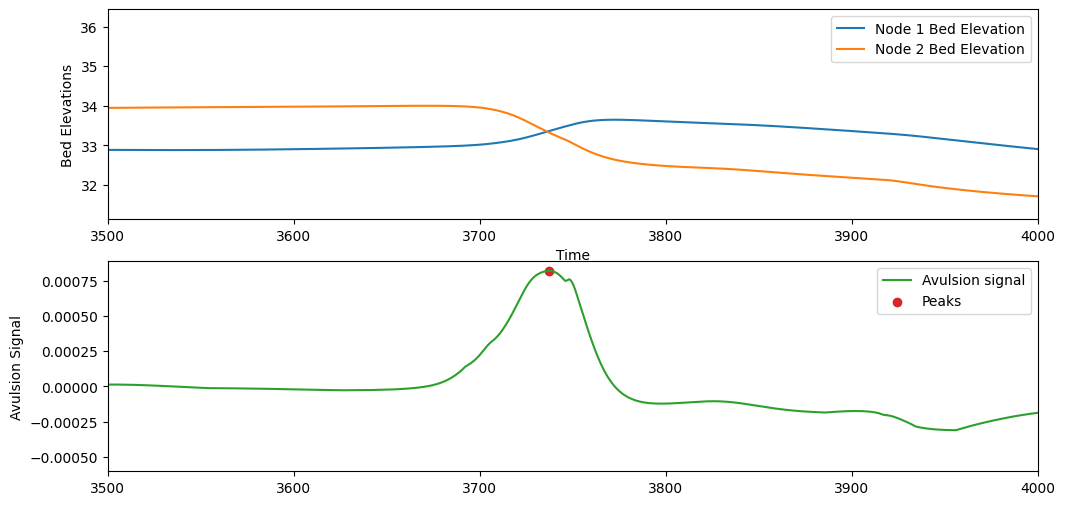

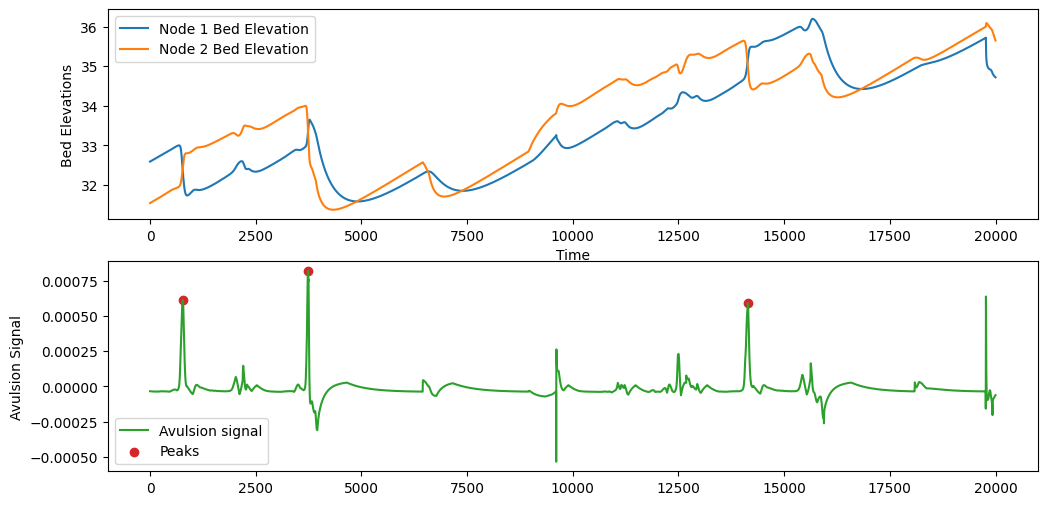

In [5]:
# Demonstrating avulsion detection

avulsion_period = 1250

bed_elevations = scipy.io.loadmat('data/7.mat')['eta_save'].T

average_elevation = (np.mean(bed_elevations[:, 1]) + np.mean(bed_elevations[:,2]))/2



# Measures how much the two elevations change in the same direction
measure_1 = np.abs(np.gradient(bed_elevations[:,2]) + np.gradient(bed_elevations[:,1])) / average_elevation

# Measures how much the two elections change in opposing directions
measure_2 = np.abs(np.gradient(bed_elevations[:,2]) - np.gradient(bed_elevations[:,1])) / average_elevation

# Rewards moving in opposite directions, penalizes moving in the same direction
measure_3 = measure_2 - measure_1
    
# Peaks are at avulsion locations, with height and width parameters manually tuned
measure_3_peaks = scipy.signal.find_peaks(measure_3, height = 0.25*np.ptp(measure_3), width = 40)[0]

# Labels: Will an avulsion occur in the next 23 days?
avulsion_coming = []
for t in range(bed_elevations.shape[0]):
    avulsion_coming.append(any((measure_3_peaks - t < avulsion_period) & (measure_3_peaks - t > 0)))


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel("Bed Elevations")
ax.set_xlabel("Time")
ax.set_xlim(3500, 4000)

ax.plot(bed_elevations[:,1], label='Node 1 Bed Elevation')
ax.plot(bed_elevations[:,2], label='Node 2 Bed Elevation')
ax.legend()
    
ax = fig.add_subplot(2,1,2)
ax.set_ylabel("Avulsion Signal")
ax.plot(measure_3, color='tab:green', label='Avulsion signal')
ax.scatter(measure_3_peaks, measure_3[measure_3_peaks], color='tab:red', label='Peaks')
ax.set_xlim(3500, 4000)
ax.legend()

plt.savefig('avulsion.pdf')

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel("Bed Elevations")
ax.set_xlabel("Time")

ax.plot(bed_elevations[:,1], label='Node 1 Bed Elevation')
ax.plot(bed_elevations[:,2], label='Node 2 Bed Elevation')
ax.legend()
    
ax = fig.add_subplot(2,1,2)
ax.set_ylabel("Avulsion Signal")
ax.plot(measure_3, color='tab:green', label='Avulsion signal')
ax.scatter(measure_3_peaks, measure_3[measure_3_peaks], color='tab:red', label='Peaks')
ax.legend()

plt.savefig('avulsions.pdf')